In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import packages
from keras.layers import Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# visualization
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def myscatter(Y, class_idxs, legend=False, ran=True, seed=229):
    if ran:
        np.random.seed(seed)
    Y = np.array(Y)
    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    classes = list(np.unique(class_idxs))
    markers = 'osD' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if ran:
        np.random.shuffle(colors)

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(Y[class_idxs == cls, 0], Y[class_idxs == cls, 1], marker=mark,
                linestyle='', ms=4, label=str(cls), alpha=1, color=colors[i],
                markeredgecolor='black', markeredgewidth=0.15)
    if legend:
        ax.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0, fontsize=10, markerscale=2, frameon=False,
                  ncol=2, handletextpad=0.1, columnspacing=0.5)

    plt.xticks([])
    plt.yticks([])

    return ax

In [ ]:
# t-SNE
def tsne(X, dim=2, ran=23):
    t_sne = TSNE(n_components=dim, random_state=ran)
    Y_tsne = t_sne.fit_transform(X)
    return Y_tsne

In [ ]:
pip install phenograph

In [ ]:
# clustering layer

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.keras.backend as K
import phenograph
from sklearn.cluster import KMeans

class ClusteringLayer(Layer):
    def __init__(self, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=None, initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def target_distribution(q):
    q = q.numpy()
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def computeCentroids(data, labels):
    n_clusters = len(np.unique(labels))
    return np.array([data[labels == i].mean(0) for i in range(n_clusters)])

def get_centers(H, mode="kmeans", n_cluster=10):
    if mode == "louvain":
        l, _,  _ = phenograph.cluster(H)
    elif mode == "kmeans":
        l = KMeans(n_clusters=n_cluster, random_state=0).fit(h).labels_
    centers = computeCentroids(H, l)
    return centers, l

In [ ]:
# read data
cells = np.array(pd.read_csv("/content/drive/My Drive/RNN/colon_cell_info.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/RNN/colon_normalize.csv", index_col=0, sep=","))

In [ ]:
# read data
cells = np.array(pd.read_csv("cotent/drive/MyDrive/CompBio/GSM3587960_AML475-D0_info_new.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("cotent/drive/MyDrive/CompBio/GSM3587960_AML475-D0_info_new.csv", index_col=0, sep="\t"))

In [ ]:
count = np.array(pd.read_csv("AML-029-08-1E_data.csv", index_col=0, sep="\t"))

In [ ]:
# read data
cells = np.array(pd.read_csv("GSM3587923_AML1012-D0_info_new.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("GSM3587923_AML1012-D0_normalize.csv", index_col=0, sep=","))

In [ ]:
# read data
cells = np.array(pd.read_csv("GSM3587991_AML921A-D0_info.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("GSM3587991_AML921A-D0_normalize.csv", index_col=0, sep=","))

In [17]:
# preprocessing
[n_sample, n_gene] = count.shape
cells = cells.flatten()
x_train = count.astype('float32')

In [18]:
from tensorflow.keras.losses import MSE, KLD
from keras.constraints import NonNeg
class AE(tf.keras.Model):

    def __init__(self, X, hidden_dim=[], latent_dim=50, impute_dim=64):
        super(AE, self).__init__()
        self.X = X

        # encoder
        
        #encoder_in = Input(shape=n_gene)
        #encoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(encoder_in)
        #encoded2 = Dense(latent_dim, activation = "relu", use_bias=True)(encoded1)
        #kernel_constraint=NonNeg(), 
        #kernel_initializer='glorot_uniform'
        
        encoder_in = Input(shape=n_gene)
        if len(hidden_dim) == 0:
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoder_in)
        elif len(hidden_dim) == 1:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        elif len(hidden_dim) == 2:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(hidden_dim[1], activation = "relu", use_bias=True)(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        else:
            encoded_list = []
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded_list.append(encoded)
            for i in range(1, len(hidden_dim)-1):
                encoded = Dense(hidden_dim[i], activation = "relu", use_bias=True)(encoded_list[i-1])
                encoded_list.append(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded_list[-1])
        encoder = Model(inputs=encoder_in, outputs=encoded, name="encoder")
    
        self.encoder = encoder
    
        # decoder
        
        #decoder_in = Input(shape=latent_dim)
        #decoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(decoder_in)
        #decoded2 = Dense(n_gene, activation = "relu", use_bias=True)(decoded1)
        #decoder = Model(inputs=decoder_in, outputs=decoded2, name="decoder")
        
        hidden_rev = hidden_dim[::-1]
        decoder_in = Input(shape=latent_dim)
        if len(hidden_dim) == 0:
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoder_in)
        elif len(hidden_dim) == 1:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        elif len(hidden_dim) == 2:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(hidden_rev[1], activation = "relu", use_bias=True)(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        else:
            decoded_list = []
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded_list.append(decoded)
            for i in range(1, len(hidden_rev)-1):
                decoded = Dense(hidden_rev[i], activation = "relu", use_bias=True)(decoded)
                decoded_list.append(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded_list[-1])
        decoder = Model(inputs=decoder_in, outputs=decoded, name="decoder")
    
        self.decoder = decoder
    
        # imputer
        impute_in = Input(shape=n_gene)
        imputed1 = Dense(impute_dim, activation = "relu")(impute_in)
        imputed2 = Dense(n_gene, activation = "relu")(imputed1)
        imputer = Model(inputs=impute_in, outputs=imputed2, name="imputer")
    
        impute_mask = np.zeros([n_sample, n_gene])
        for i in range(n_sample):
            for j in range(n_gene):
                if count[i,j] == 0:
                    impute_mask[i,j] = 1
        self.mask = tf.convert_to_tensor(impute_mask, dtype=tf.float32)
    
        self.imputer = imputer
    
        # clustering
        clustering_layer = ClusteringLayer(name='clustering')(encoded)
        clustering_model = Model(inputs=encoder_in, outputs=clustering_layer, name="cluster")
    
        self.clustering = clustering_model
    
    # pre-training
    def train(self, T=2, max_epoch=100, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            with tf.GradientTape(persistent=True) as tape:
                
                x = self.X
                loss = 0
                
                for t in range(T):
                    h = self.encoder(x)
                    y = self.decoder(h)
                    
                    v = self.imputer(y)
                    x = self.X + tf.multiply(self.mask, v)
                    
                    loss += tf.reduce_mean(MSE(self.X, y))
                    
                if loss / T < 0.5:
                    break;

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 5 == 0:
                print(loss)
        print("Finish!")
        
    # clustering training
    def clustering_train(self, centers, wc=2.5, max_epoch=30, learning_rate=0.0001):
        
        self.clustering.get_layer(name='clustering').clusters = centers
        
        q = self.clustering(x_train)
        p = target_distribution(q)
        
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            if epoch % 10 == 0:
                #centers, labels = get_centers(np.array(h), mode=mode, n_cluster=n_cluster)
                #self.clustering.get_layer(name='clustering').clusters = centers
                q = self.clustering(self.X)
                p = target_distribution(q)
            with tf.GradientTape(persistent=True) as tape:
                
                h = self.encoder(self.X)
                y = self.decoder(h)
                    
                loss = tf.reduce_mean(MSE(self.X, y))
                
                q_out = self.clustering(self.X)
                
                #if epoch % 10 == 0:
                    #print(q_out)
                
                cluster_loss = tf.reduce_mean(KLD(q_out, p))
                loss += wc * cluster_loss

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 10 == 0:
                print(loss)
                print(cluster_loss)
        print("Finish!")

In [19]:
autoencoder = AE(x_train, hidden_dim=[1000], latent_dim=50, impute_dim=64)

In [20]:
autoencoder.train(T=2, max_epoch=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(183.75323, shape=(), dtype=float32)
tf.Tensor(180.71298, shape=(), dtype=float32)
tf.Tensor(175.81932, shape=(), dtype=float32)
tf.Tensor(167.72897, shape=(), dtype=float32)
tf.Tensor(155.34862, shape=(), dtype=float32)
tf.Tensor(138.7467, shape=(), dtype=float32)
tf.Tensor(120.50516, shape=(), dtype=float32)
tf.Tensor(103.65904, shape=(), dtype=float32)
tf.Tensor(89.497925, shape=(), dtype=float32)
tf.Tensor(78.15497, shape=(), dtype=float32)
Finish!


In [21]:
h = autoencoder.encoder(x_train)

In [22]:
ed = tsne(h)

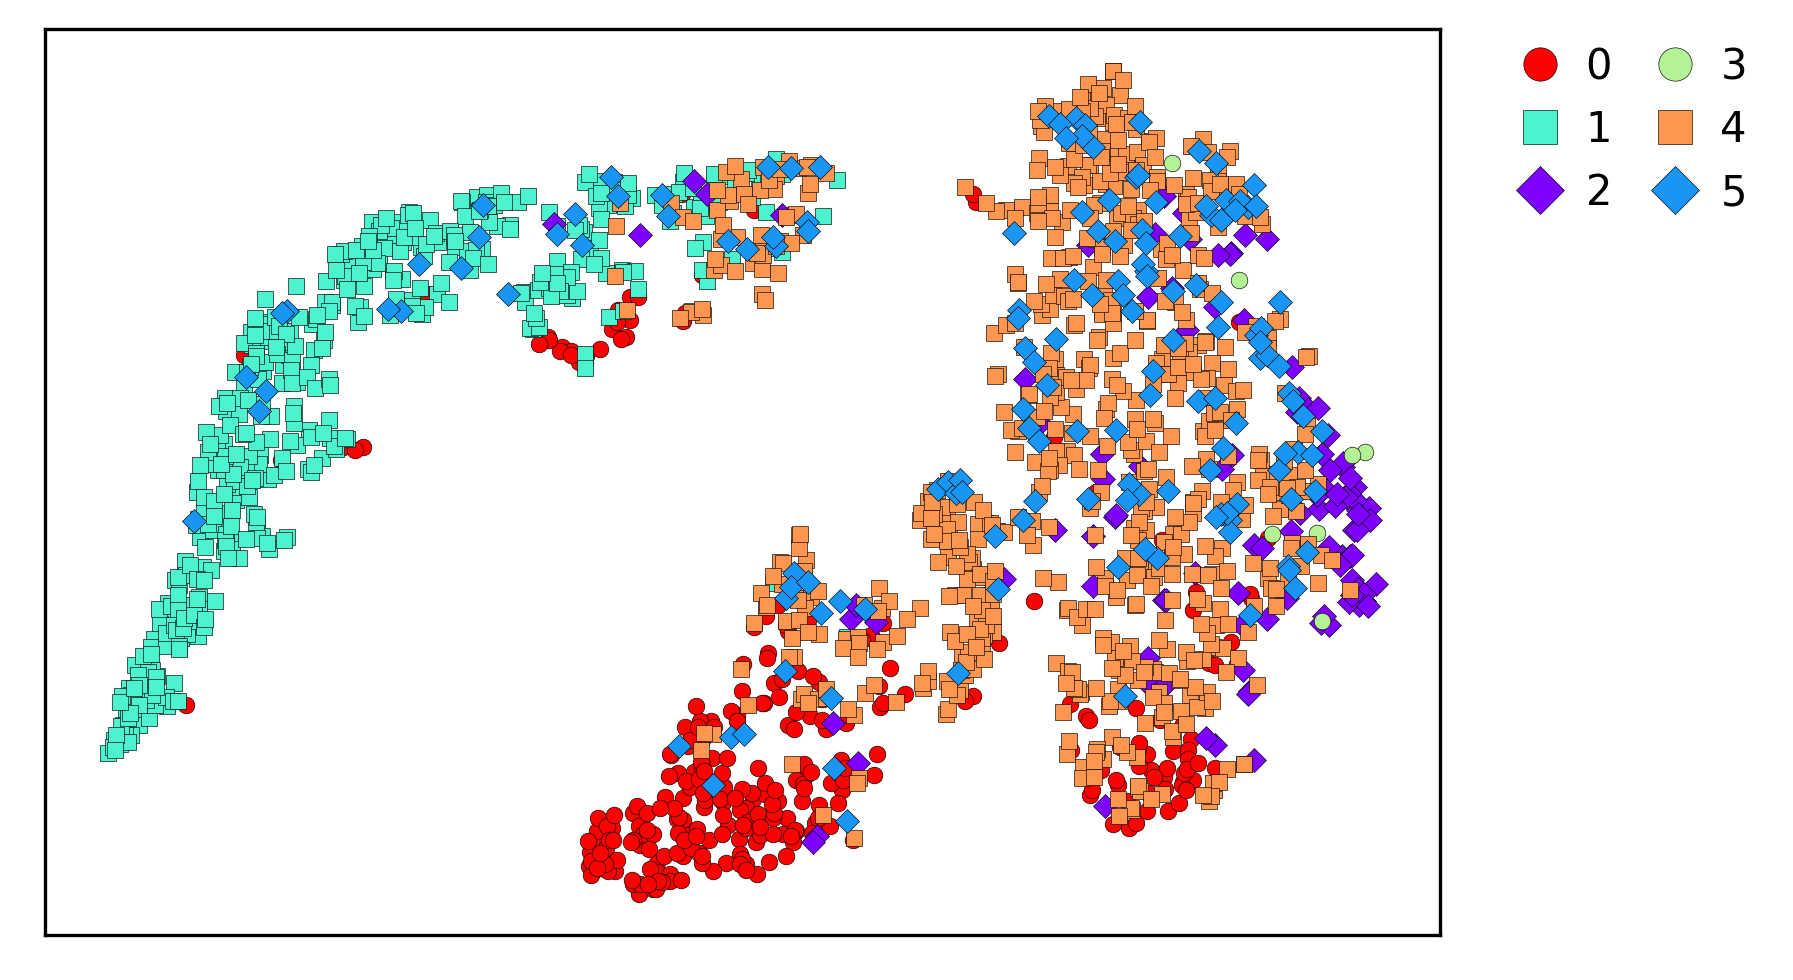

In [23]:
myscatter(ed, cells, legend=True)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.16178059577941895 seconds
Jaccard graph constructed in 0.6014859676361084 seconds
Wrote graph to binary file in 0.02787160873413086 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.813136
After 2 runs, maximum modularity is Q = 0.815142
After 6 runs, maximum modularity is Q = 0.817177
Louvain completed 26 runs in 1.5093092918395996 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 2.54154896736145 seconds


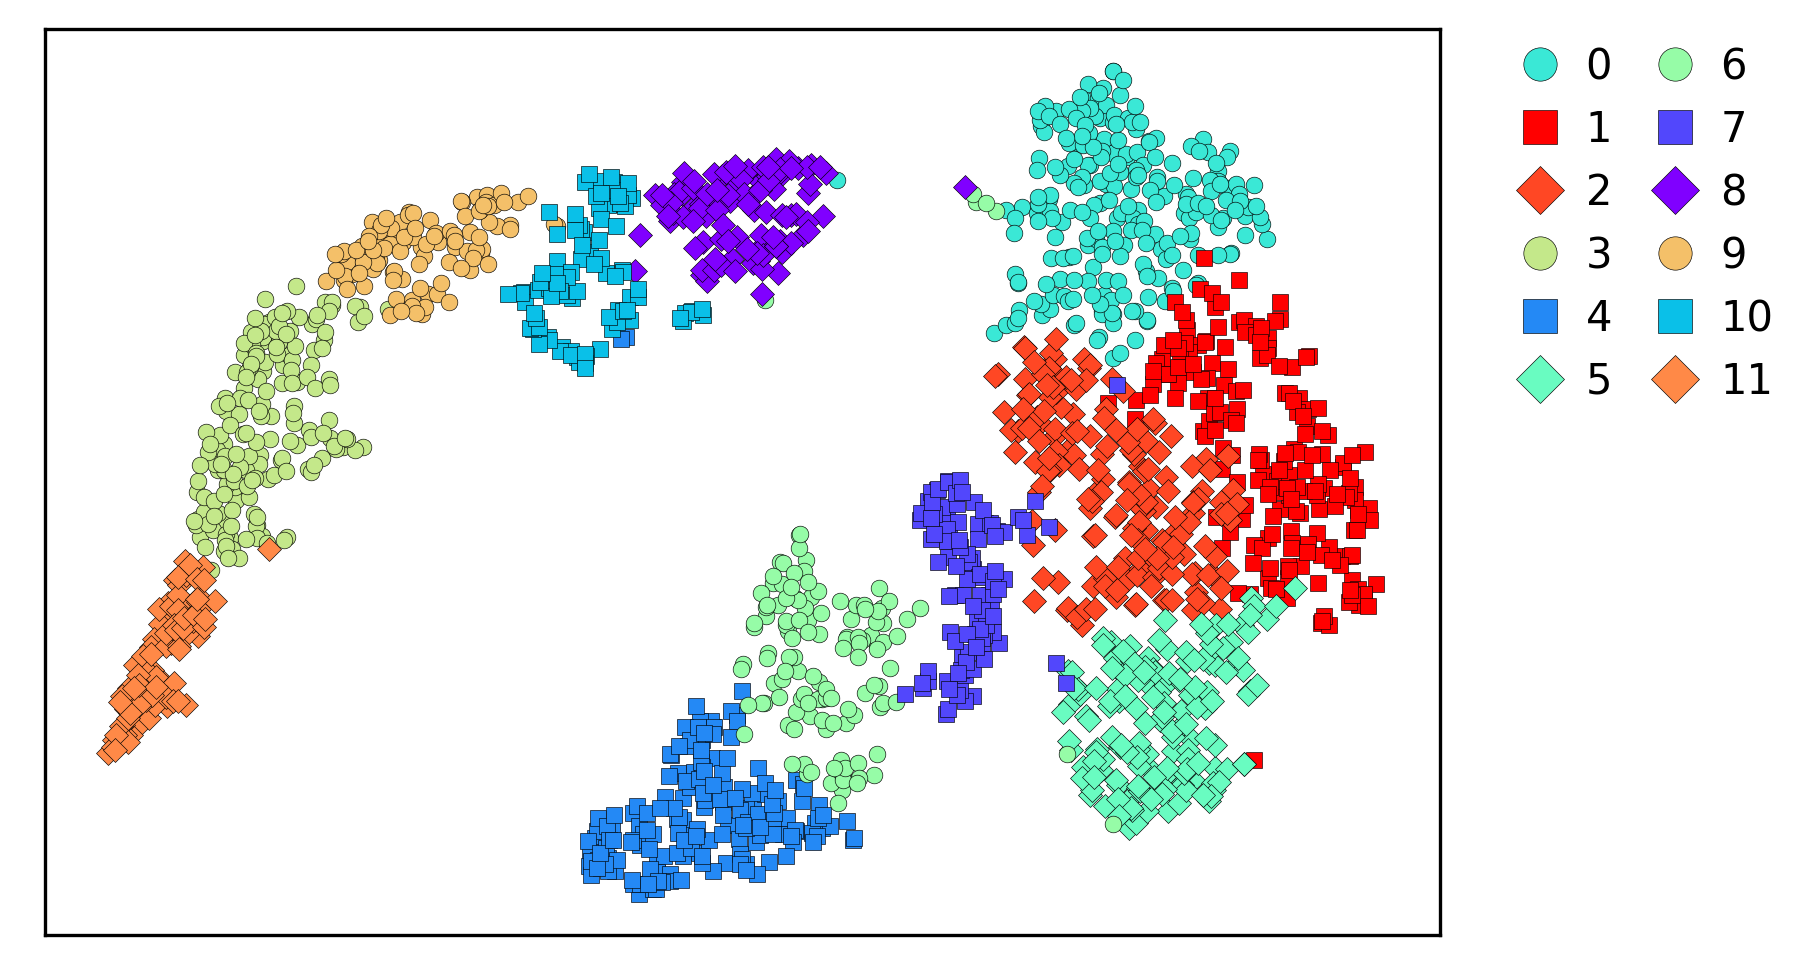

In [24]:
centers, labels = get_centers(np.array(h), mode="louvain", n_cluster=5)
myscatter(ed,labels, legend=True)

In [25]:
autoencoder.clustering_train(centers, wc=5, max_epoch=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(38.28024, shape=(), dtype=float32)
tf.Tensor(0.3830271, shape=(), dtype=float32)
tf.Tensor(34.485386, shape=(), dtype=float32)
tf.Tensor(0.3844724, shape=(), dtype=float32)
tf.Tensor(31.701933, shape=(), dtype=float32)
tf.Tensor(0.38539484, shape=(), dtype=float32)
tf.Tensor(29.369392, shape=(), dtype=float32)
tf.Tensor(0.3814519, shape=(), dtype=float32)
tf.Tensor(27.175232, shape=(), dtype=float32)
tf.Tensor(0.37833476, shape=(), dtype=float32)
Finish!


In [26]:
h = autoencoder.encoder(x_train)

In [27]:
ed = tsne(h)

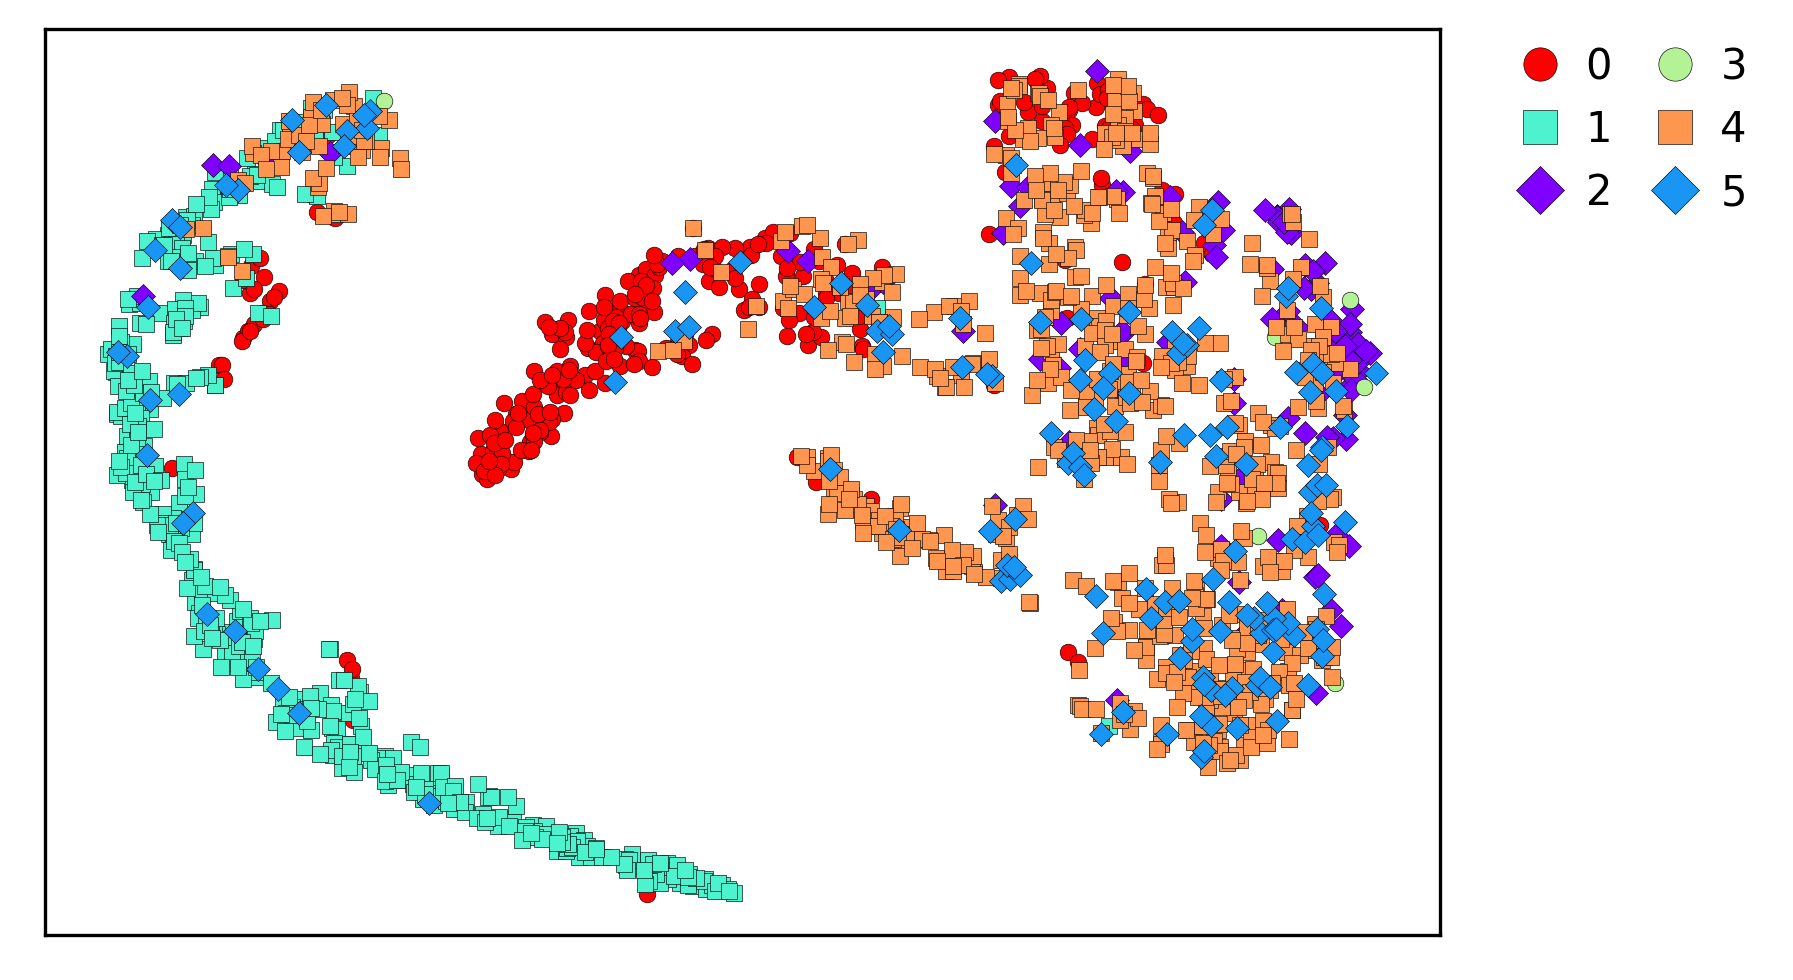

In [28]:
myscatter(ed, cells, legend=True)

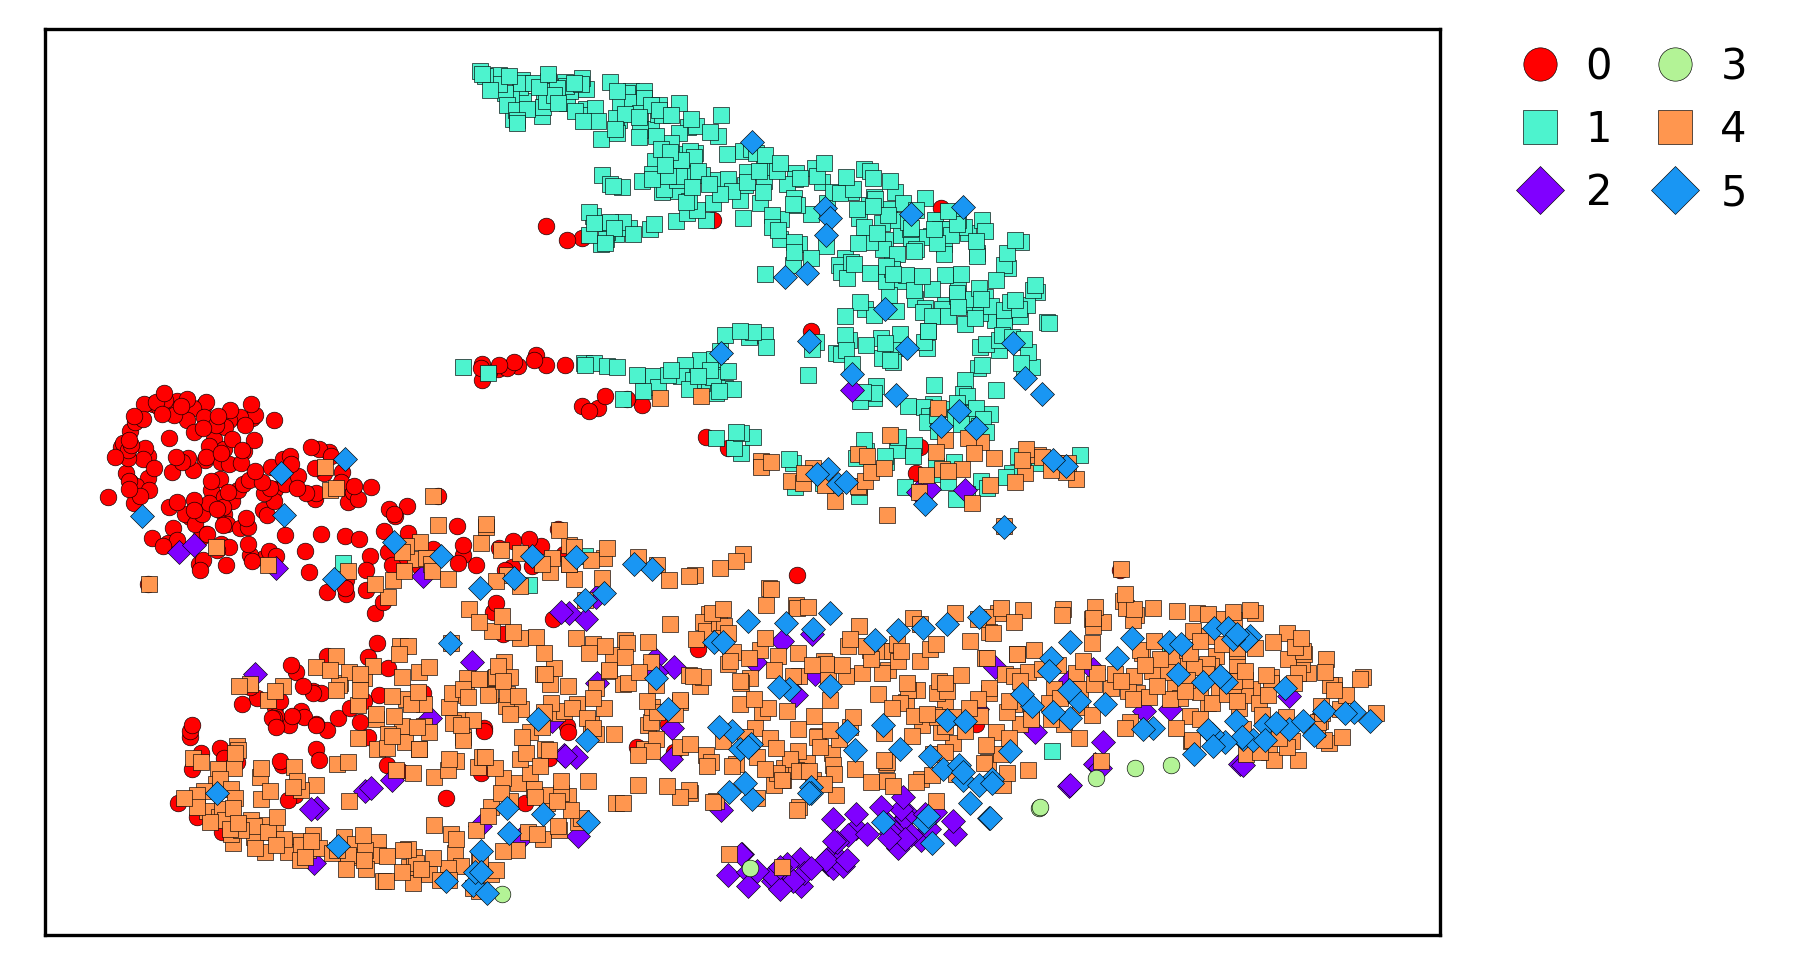

In [29]:
ed = tsne(count)
myscatter(ed, cells, legend=True)

In [30]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score
def measure(true, pred):
    NMI = round(normalized_mutual_info_score(true, pred), 2)
    RAND = round(adjusted_rand_score(true, pred), 2)
    HOMO = round(homogeneity_score(true, pred), 2)
    COMP = round(completeness_score(true, pred), 2)
    return [NMI, RAND, HOMO, COMP]

In [31]:
labels_new, _,  _ = phenograph.cluster(np.array(h))
measure(cells, labels)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2079160213470459 seconds
Jaccard graph constructed in 1.0423943996429443 seconds
Wrote graph to binary file in 0.07011699676513672 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.85834
Louvain completed 21 runs in 1.503401279449463 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.0428261756896973 seconds


[0.37, 0.19, 0.5, 0.29]

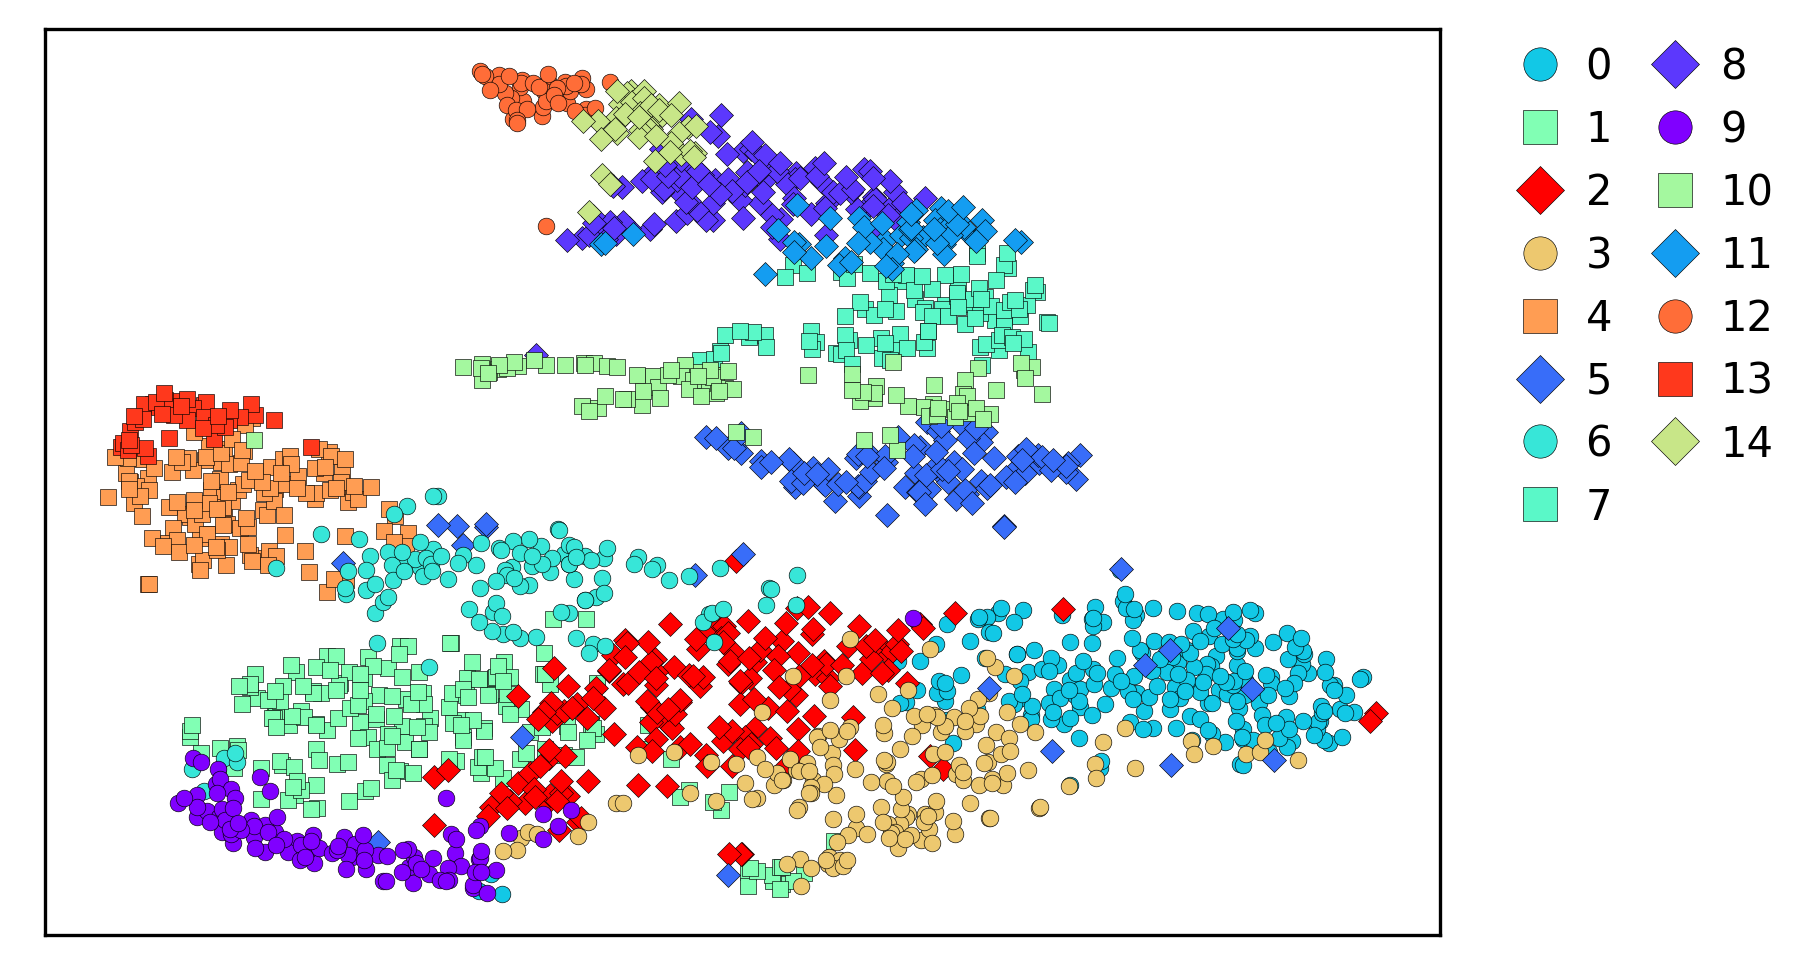

In [32]:
myscatter(ed, labels_new, legend=True)

In [33]:
labels_new = KMeans(n_clusters=10, random_state=0).fit(np.array(h)).labels_
measure(cells, labels)

[0.37, 0.19, 0.5, 0.29]

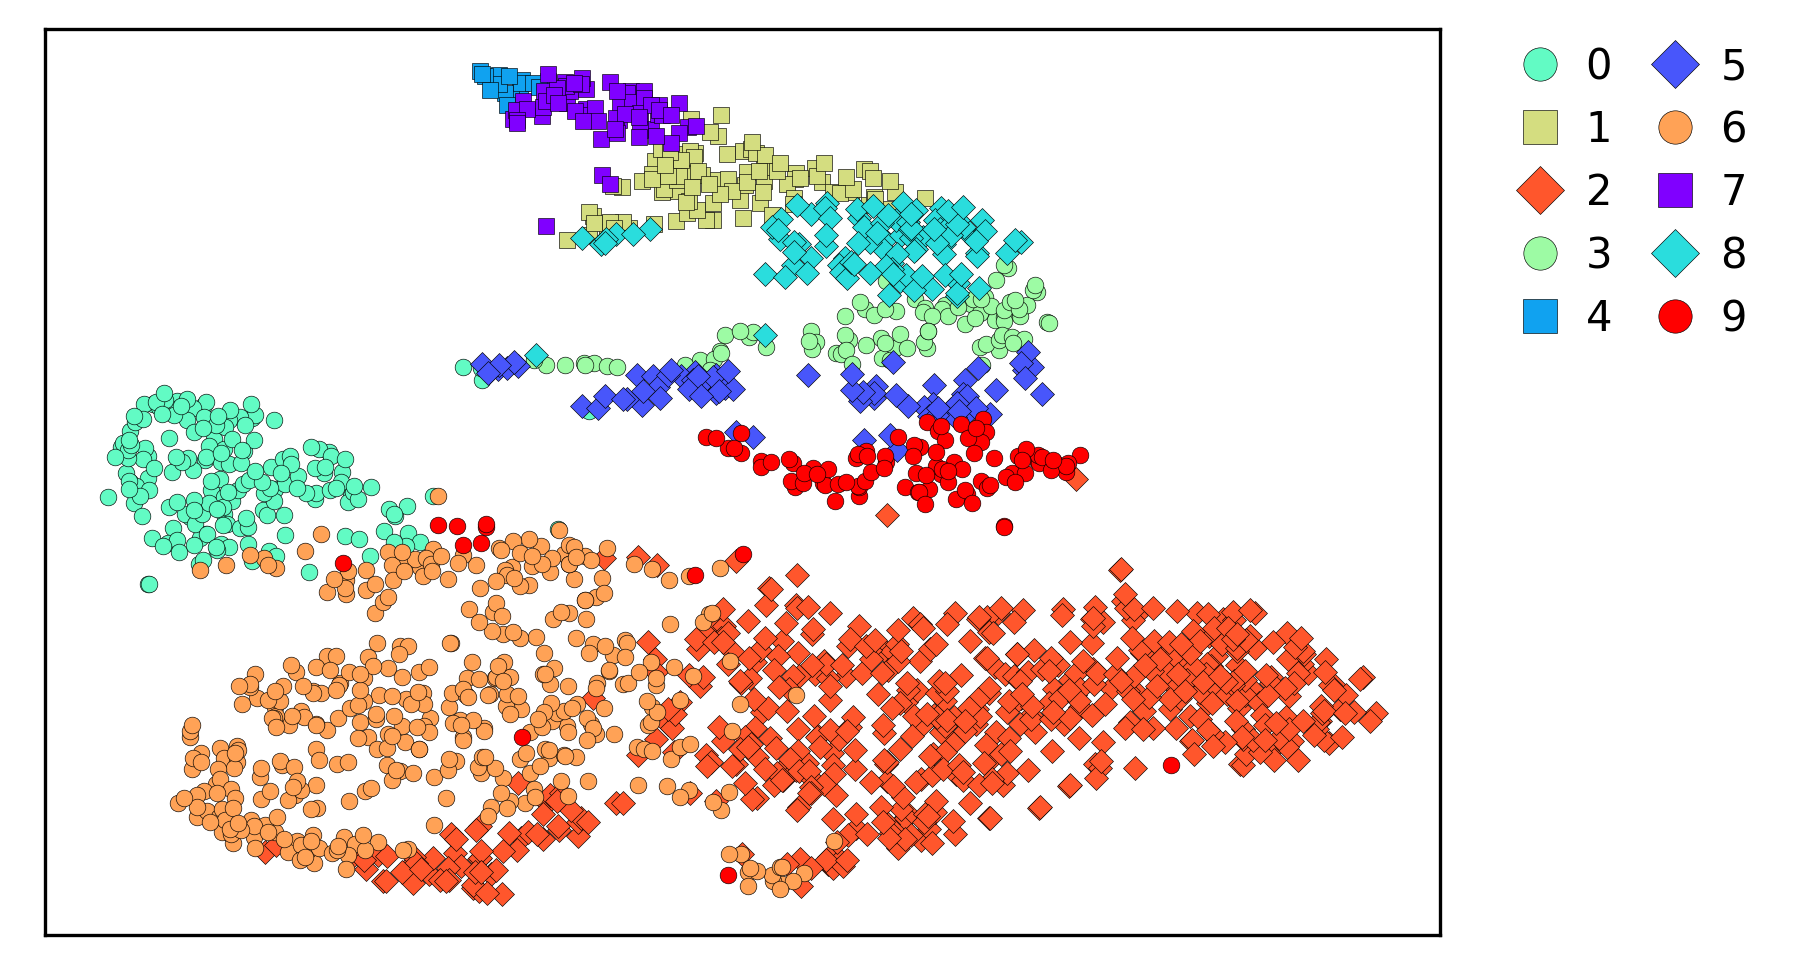

In [34]:
myscatter(ed,labels_new, legend=True)

In [35]:
from scipy.spatial.distance import cdist
dist_mat = cdist(h, h, 'euclidean')

In [36]:
save = pd.DataFrame(dist_mat)
save.to_csv('GSM3587923_AML1012-D0_dist.csv',index=False,header=True)

In [37]:
y_test = cells
y_pred = labels_new

In [38]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[167   2   6   4   0  12  96   1   3   6]
 [  1  94   2  84  17  54   2  61  89  38]
 [  2   0  62   0   0   1  36   0   0   4]
 [  0   0   5   0   0   0   1   0   0   1]
 [  8   0 387   0   0   4 265   0   0  47]
 [  5   1 101   5   0   5  19   0   7  10]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.1912536443148688

In [40]:
save = pd.DataFrame(cf_matrix)
save.to_csv('GSM3587923_AML1012-D0_matrix.csv',index=False,header=True)

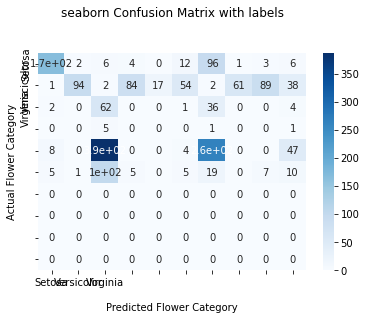

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Flower Category')
ax.set_ylabel('Actual Flower Category');
##Ticker labels-List must be in alphabetical order
ax.xaxis.set_ticklabels(['Setosa','Versicolor','Virginia'])
ax.yaxis.set_ticklabels(['Setosa','Verscicolor','Virginia'])

##Display the visualization of the Confusion Matrix.
plt.show()